# Jet modeling for pipe ruptures

Calculation line for modeling of jets caused by high energy pipe ruptures, for initially subcooled water and flashing discharge, according to the recommendations of NEI 04-07 (2004). The calculation line consists in the following steps:
1. Mass flux modeling, according to Henry-Fauske model, for subcooled water blowdown through  nozzles, based on a homogeneous non-equilibrium flow proces.
2. Jet thrust force modeling, according to Appendix B of ANSI/ANS 58.2-1988.
3. Jet geometry modeling, according to Appendix C of ANSI/ANS 58.2-1988.
4. Modeling of the pressure distribution inside the jet, according to Appendix D of ANSI/ANS 58.2-1988.

Results are validated by means of comparison of mass flux results presented in NUREG/CR-7275 (2021) and isobars curves presented in NEI 04-07 (2004).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm

In [2]:
from iapws import IAPWS95 as wp

In [3]:
# Units conversion constants

BTU_lb2kJ_kg = 2.326 # BTU/lb a kJ/kg
psi2MPa = 0.006894757 # PSI a MPa
ft2m = 0.3048 # ft a m
dF2dK = 5/9 # delta ºF a delta ºK
lb_ft22kg_m2 = 4.882427636 # lb/ft2 a kg/m2

Inputs: Pipe rupture parameters

In [4]:
# Sample calculation by NEI 04-07 Vol. 2, Case 10 (page 220)
P0 = 1040*psi2MPa # MPa. Presión de estancamiento de la línea
T0 = 488.71 # K. Temperatura del agua. Equivalente a 420 ºF
De = 1 # mm. Diámetro de la línea = Diámetro de la rotura
Pamb = 14.7*psi2MPa # MPa. Presión ambiente

In [5]:
# Sample calculation by NEI 04-07 Vol. 1 (page 103)
P0 = 2250*psi2MPa # MPa. Stagnation pressure of the line
T0 = 555.37 # K. Water temperature. Equivalent to 540 ºF
De = 1 # mm. Break diameter
Pamb = 14.7*psi2MPa # MPa. Ambient pressure

Dependent parameters

In [6]:
Ae = np.pi * (De/2)**2 # mm2
Psat = wp(T=T0, x=0).P # MPa
Tsat = wp(P=P0, x=0).T # K
DTsub = Tsat-T0 # K
rho0 = wp(T=T0, P=P0).rho # kg/m3
h0 = wp(P=P0, T=T0).h # kJ/kg

# 1. Critical mass flux: Henry-Fauske model

3 implementations of the same model are presented:
* Method 1: Analytical solution by iteration of equations presented in Henry (1970), "The Two-Phase Critical Discharge of Initially Saturated or Subcooled Liquid".
* Method 2: Interpolation from map presented in Kim (2015), "Critical flow maps using an extended Henry–Fauske model" (Figure 8).
* Method 3: Interpolation from map presented in NEI 04-07 (2004) Vol. 2 (Figure I-6).

### Method 1

$$
\begin{cases}
G_e^2 = -\left( (v_g - v_{l0})N\frac{dx_E}{dP} \right)^{-1} \\
P_0 - P_e = \frac{1}{2}G_c^2 v_{l0}
\end{cases}
$$

In [7]:
def xE(Pt, P0, T0):
    s0 = wp(P=P0, T=T0).s
    return (s0 - wp(P=Pt, x=0).s) / (wp(P=Pt, x=1).s - wp(P=Pt, x=0).s)
def dxE_dP(Pt, P0, T0):
    x = xE(Pt, P0, T0)
    dP = 1e-6 # MPa
    dsf_dP = (wp(P=Pt+dP, x=0).s - wp(P=Pt, x=0).s) / dP # kJ/(kg*K*MPa)
    dsg_dP = (wp(P=Pt+dP, x=1).s - wp(P=Pt, x=1).s) / dP # kJ/(kg*K*MPa)
    return -((1-x)*dsf_dP + x*dsg_dP) / (wp(P=Pt, x=1).s - wp(P=Pt, x=0).s) # 1/MPa
def xt(Pt, P0, T0):
    xEt = xE(Pt, P0, T0)
    N = 20 * xEt if xEt < 0.05 else 1.
    B = 0.0523
    L_D = 0
    return N * xEt * (1 - np.exp(-B*(L_D)))
def Gc(Pt, P0, T0):
    xEt = xE(Pt, P0, T0)
    dxE_dPt = dxE_dP(Pt, P0, T0)
    N = 20 * xEt if xEt < 0.05 else 1.
    x = xt(Pt, P0, T0)
    vg = wp(P=Pt, x=1).v # m3/kg
    vf0 = wp(P=P0, T=T0).v # m3/kg
    #return 1e-3 / np.sqrt(x*vg/Pt - (vg-vf0)*N*dxE_dPt) # kg/s/mm2
    #return 1e-3 / np.sqrt(- (vg-vf0)*N*dxE_dPt) # kg/s/mm2
    return 1e-3 / np.sqrt(- (vg-vf0)*N*dxE_dPt) # kg/s/mm2
def Pt(Gc, Pt_1, P0, T0):
    vf0 = wp(P=P0, T=T0).v # m3/kg
    #vgt = wp(P=Pt_1, x=1).v # m3/kg
    C = 1
    x = xt(Pt_1, P0, T0)
    #return P0 - 1e6*Gc**2*(vf0/(2*C**2) + x*(vgt-vf0)) # MPa
    return P0 - 1e6*Gc**2*(vf0/(2*C**2)) # MPa

In [8]:
def Gcrit1(P0, T0, alpha=0.01, rP0=0.95, rtol=0.00001):
    Pe = rP0*wp(T=T0, x=0).P
    Ge = Gc(Pe, P0, T0)
    dG = Ge
    i = 0
    while dG > rtol*Ge:
        print("Iteration: {}, dG/tol = {:.2f}\r".format(i, dG/(rtol*Ge)), end="")
        Pe = Pe + alpha*(Pt(Ge, Pe, P0, T0) - Pe)
        Ge_1 = Ge
        Ge = Gc(Pe, P0, T0)
        dG = np.abs(Ge_1-Ge)
        i = i+1
    print("\nConverged. Pe/Psat0 = {:.3f}".format(Pe/wp(T=T0, x=0).P))
    return Ge

Ge1 = Gcrit1(P0, T0, alpha=0.01, rP0=0.94)
print(Ge1)

Iteration: 3, dG/tol = 17.217800
Converged. Pe/Psat0 = 0.938
0.1188488499413359


### Method 2

In [9]:
import re
def read_data(filename): # Leer data files de GraphGrabber
    f = open(filename, mode='r')
    ls = f.readlines()
    lss = re.split('Series [0-9]*: \n', ''.join(ls))[1:]
    f.close()
    return [np.fromstring(l[:-1].replace('\n', ';'), sep=';').reshape(-1,2) for l in lss]

In [10]:
def Gcrit2(P0, h0):
    Ge__ = read_data("graficas/Kim - Fig 8.csv")
    Gref = 1e-3 # kg/s/mm2
    href = 2e2 # kJ/kg
    Pref = 1 # MPa
    P0_ = Pref * np.array([0.5, 1, 2, 3, 4, 5, 6, 7, 10, 12, 15, 20])
    Ge_ = [Gref * np.interp(h0/href, Ge[:,0], Ge[:,1]) for Ge in Ge__]
    Ge = np.interp(P0/Pref, P0_, Ge_)
    return Ge

Ge2 = Gcrit2(P0, h0)
print(Ge2)

0.11962783555875169


### Method 3

In [11]:
def Gcrit3(P0, T0):
    Ge__ = read_data("graficas/NEI 04-07 V2 - Fig I-6.csv")
    Ge_ = np.array([3000, 12000, 15000, 18000, 21000, 24000, 27000, 30000, 33000]) * lb_ft22kg_m2 * 1e-6 # kg/s/mm2
    P_ = [np.interp(T0, Ge[:,0], Ge[:,1]) for Ge in Ge__]
    Ge = np.interp(P0/psi2MPa, P_, Ge_)
    return Ge

Ge3 = Gcrit3(P0, T0)
print(Ge3)

0.12017444491090355


### Comparison agaist the results presented in NUREG/CR-7275 (2021), Figure 3-60.

Iteration: 8, dG/tol = 3.0773450
Converged. Pe/Psat0 = 0.987
Iteration: 18, dG/tol = 1.226410
Converged. Pe/Psat0 = 0.966
Iteration: 27, dG/tol = 1.169050
Converged. Pe/Psat0 = 0.953
Iteration: 32, dG/tol = 1.254140
Converged. Pe/Psat0 = 0.945
Iteration: 34, dG/tol = 1.235875
Converged. Pe/Psat0 = 0.939
Iteration: 35, dG/tol = 1.046301
Converged. Pe/Psat0 = 0.934
Iteration: 51, dG/tol = 1.192328
Converged. Pe/Psat0 = 0.930
Iteration: 88, dG/tol = 1.1190414
Converged. Pe/Psat0 = 0.926

Converged. Pe/Psat0 = 0.980

Converged. Pe/Psat0 = 0.980


C:\Users\iabbate\AppData\Local\Temp\ipykernel_15596\3194232646.py:25: RuntimeWarning: invalid value encountered in sqrt
  return 1e-3 / np.sqrt(- (vg-vf0)*N*dxE_dPt) # kg/s/mm2


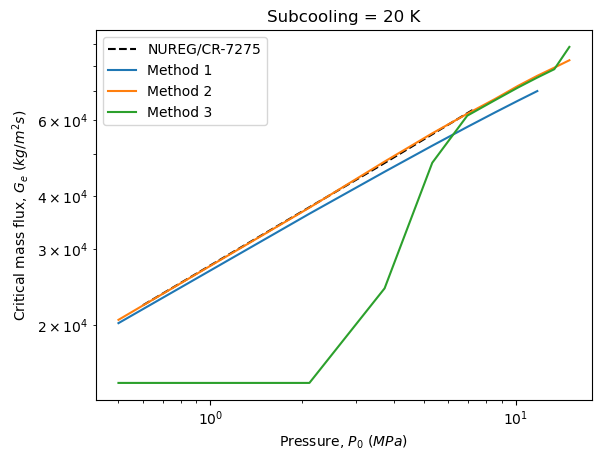

Iteration: 6, dG/tol = 2.6005950
Converged. Pe/Psat0 = 0.993
Iteration: 27, dG/tol = 1.132380
Converged. Pe/Psat0 = 0.979
Iteration: 32, dG/tol = 1.162.59
Converged. Pe/Psat0 = 0.968
Iteration: 88, dG/tol = 1.024118
Converged. Pe/Psat0 = 0.960

Converged. Pe/Psat0 = 0.990

Converged. Pe/Psat0 = 0.990

Converged. Pe/Psat0 = 0.990

Converged. Pe/Psat0 = 0.990

Converged. Pe/Psat0 = 0.990

Converged. Pe/Psat0 = 0.990


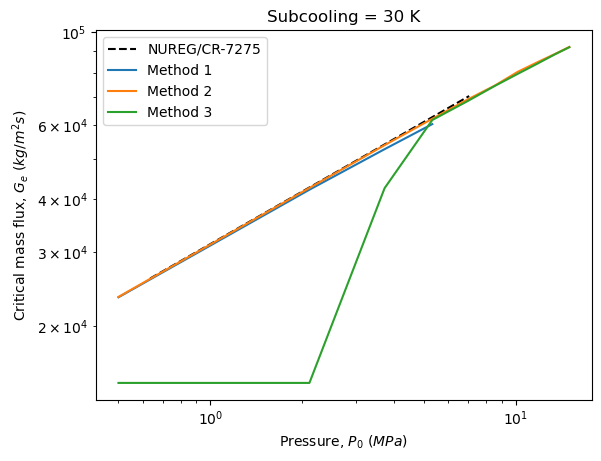

Iteration: 18, dG/tol = 1.423510
Converged. Pe/Psat0 = 0.996
Iteration: 32, dG/tol = 1.157100
Converged. Pe/Psat0 = 0.985
Iteration: 47, dG/tol = 1.046700
Converged. Pe/Psat0 = 0.976
Iteration: 68, dG/tol = 1.037510
Converged. Pe/Psat0 = 0.969
Iteration: 83, dG/tol = 1.010470
Converged. Pe/Psat0 = 0.963
Iteration: 60, dG/tol = 1.064.93
Converged. Pe/Psat0 = 0.957

Converged. Pe/Psat0 = 0.980

Converged. Pe/Psat0 = 0.980

Converged. Pe/Psat0 = 0.980

Converged. Pe/Psat0 = 0.980


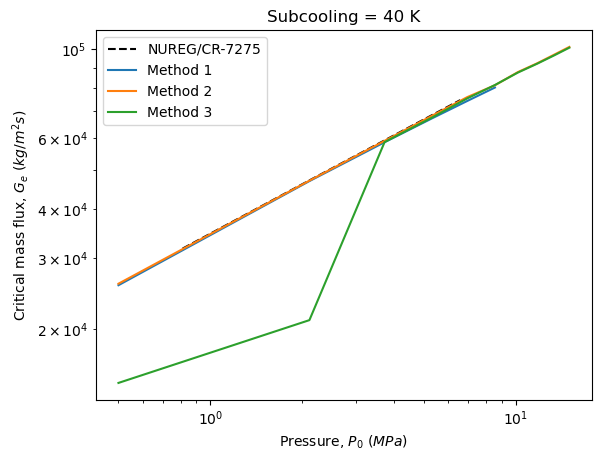

In [12]:
P_ = np.linspace(0.5, 15, 10)
G__ = read_data("graficas/NUREG CR-7275 - Fig 3-60.csv")

# Subcooling = 20 K
T_ = [wp(P=P, x=0).T-20 for P in P_]
plt.plot(G__[0][:,0], G__[0][:,1], 'k--', label="NUREG/CR-7275")

Ge1_20K_ = [Gcrit1(P,T, alpha=0.02, rP0=0.98)*1e6 for (P,T) in zip(P_,T_)]
plt.plot(P_, Ge1_20K_, label='Method 1')

h_ = [wp(P=P, T=T).h for (P,T) in zip(P_,T_)]
Ge_ = [Gcrit2(P,h)*1e6 for (P,h) in zip(P_,h_)]
plt.plot(P_, Ge_, label='Method 2')

Ge_ = [Gcrit3(P,T)*1e6 for (P,T) in zip(P_,T_)]
plt.plot(P_, Ge_, label='Method 3')

plt.legend()
plt.xlabel(r"Pressure, $P_0\ (MPa)$")
plt.ylabel(r"Critical mass flux, $G_e\ (kg/m^2s)$")
plt.xscale('log')
plt.yscale('log')
plt.title("Subcooling = 20 K")
plt.show()

# Subcooling = 30 K
T_ = [wp(P=P, x=0).T-30 for P in P_]
plt.plot(G__[1][:,0], G__[1][:,1], 'k--', label="NUREG/CR-7275")

Ge1_30K_ = [Gcrit1(P,T, alpha=0.005, rP0=0.99)*1e6 for (P,T) in zip(P_,T_)]
plt.plot(P_, Ge1_30K_, label='Method 1')

h_ = [wp(P=P, T=T).h for (P,T) in zip(P_,T_)]
Ge_ = [Gcrit2(P,h)*1e6 for (P,h) in zip(P_,h_)]
plt.plot(P_, Ge_, label='Method 2')

Ge_ = [Gcrit3(P,T)*1e6 for (P,T) in zip(P_,T_)]
plt.plot(P_, Ge_, label='Method 3')

plt.legend()
plt.xlabel(r"Pressure, $P_0\ (MPa)$")
plt.ylabel(r"Critical mass flux, $G_e\ (kg/m^2s)$")
plt.xscale('log')
plt.yscale('log')
plt.title("Subcooling = 30 K")
plt.show()

# Subcooling = 40 K
T_ = [wp(P=P, x=0).T-40 for P in P_]
plt.plot(G__[2][:,0], G__[2][:,1], 'k--', label="NUREG/CR-7275")

Ge1_40K_ = [Gcrit1(P,T, alpha=0.002, rP0=0.98)*1e6 for (P,T) in zip(P_,T_)]
plt.plot(P_, Ge1_40K_, label='Method 1')

h_ = [wp(P=P, T=T).h for (P,T) in zip(P_,T_)]
Ge_ = [Gcrit2(P,h)*1e6 for (P,h) in zip(P_,h_)]
plt.plot(P_, Ge_, label='Method 2')

Ge_ = [Gcrit3(P,T)*1e6 for (P,T) in zip(P_,T_)]
plt.plot(P_, Ge_, label='Method 3')

plt.legend()
plt.xlabel(r"Pressure, $P_0\ (MPa)$")
plt.ylabel(r"Critical mass flux, $G_e\ (kg/m^2s)$")
plt.xscale('log')
plt.yscale('log')
plt.title("Subcooling = 40 K")
plt.show()

As can be observed, methods 1 and 2 agree within the values from NUREG/CR-7275, but method 2 has a lower error. Method 3 agrees with the values from NUREG/CR-7275 within its valid pressure range, which is notably lower than the valid range for method 2. Furthermore, methods 2 and 3 are much faster to evaluate than method 1 (analytical iteration).

Therefore, method 2 is used.

In [13]:
Ge = Ge2

# 2. Thrust force:
### ANSI/ANS-58.2-1988, Appendix B, Section B2. Steady State Thrust Force:
Subsection (c) Subcooled Water: Henry-Fauske model for sub-cooled water blowdown through nozzles:

$$
C_T = \frac{T}{P_0 A_e} = 
\begin{cases}
2.0 - 0.861 (h^*)^2 & 0 \leq h^* < 0.75 \\
3.22 - 3.0 h^* - 0.97 (h^*)^2 & 0.75 \leq h^* \leq 1
\end{cases}
$$

with $ h^* = \frac{h_0 - 180\ BTU/lb}{h_{sat} - 180\ BTU/lb} $, $T$: jet thrust force.

In [14]:
def CT(P, h):
    hsat = wp(P=P, x=0).h # kJ/kg
    hx = (h - 180 * BTU_lb2kJ_kg) / (hsat - 180* BTU_lb2kJ_kg)
    CT = 2.0 - 0.861 * hx**2 if hx < 0.75 else 3.22 - 3.0 * hx + 0.97 * hx**2
    return CT
CT0 = CT(P0, h0)
CT0

1.6004432242813118

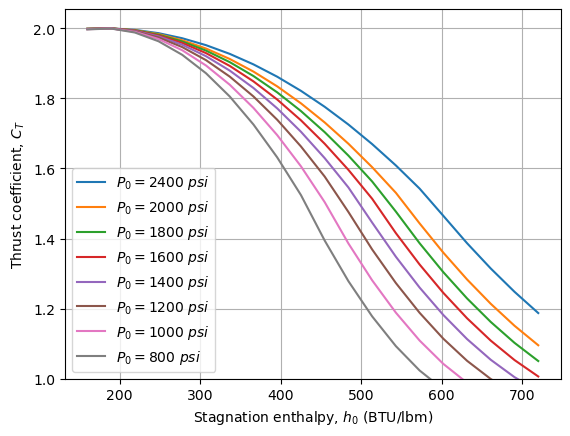

In [15]:
h_ = np.linspace(160, 720, 20)*BTU_lb2kJ_kg # kJ/kg
for P in [2400, 2000, 1800, 1600, 1400, 1200, 1000, 800]:
    CT_ = np.array([CT(P*psi2MPa, h) for h in h_])
    plt.plot(h_ / BTU_lb2kJ_kg, CT_, label=r"$P_0 = {0:.0f}\ psi$".format(P))

plt.xlabel("Stagnation enthalpy, $h_0$ (BTU/lbm)")
plt.ylabel("Thrust coefficient, $C_T$")
plt.ylim(bottom=1.0)
plt.legend()
plt.grid()
plt.show()

This figure matches Figure B-6 from ANSI/ANS 58.2-1988.

# 3. Jet geometry
### ANSI/ANS-58.2-1988, Appendix C, Section C1.1 Circumferential Break with Full Separation:

With $C_T$: Thrust coefficient

### Region 1: Jet core

- Jet length: $\frac{L_c}{D_e} = 0.26 \sqrt{\Delta T_{sub}}+0.5$, with $\Delta T_{sub}\ [ºF]$.

- Jet exit area: $A_{je} = C_{T} A_e$.

- Jet core diameter: $\frac{D_c}{D_e} = \sqrt{C_{T}}(1-\frac{L}{L_c})$

### Region 2: Jet expansion until asymptotic plane

- Asymptotic plane pressure:
      $$\frac{P_a}{P_{amb}} = 1 - 0.5 (1 - \frac{2P_{amb}}{P_0})f $$
      with
    $
    f =\begin{cases}
    \sqrt{0.1+\frac{h_0-h_f}{h_{fg}}} & \frac{h_0-h_f}{h_{fg}} > -0.1 \\
    0 & \frac{h_0-h_f}{h_{fg}} < -0.1
    \end{cases}
    $
    , for $h_f$ and $h_{fg}$ evaluated at $P_0$.

- Asymptotic area:
      $$\frac{A_a}{A_e} = \frac{G_e^2}{\rho_{ma} C_T P_0}$$
      with $\rho_{ma} = \frac{1}{x/\rho_g+(1-x)/\rho_f}$ for $P=P_a$.

- Asymptotic plane length: $$\frac{L_a}{D_e} = \frac{1}{2} \left(\sqrt{\frac{A_a}{A_e}}-1\right)$$
 
- Jet area (Regions 1 and 2): $$ \frac{A_j}{A_{je}} = 1+\frac{L}{L_a}\left(\frac{A_a}{A_{je}}-1\right) $$

### Region 3: Jet expansion beyond the asymptotic plane

- Jet area: $$ \frac{A_j}{A_{a}} = \left(1+\frac{2(L-L_a)}{D_a}tan(10º)\right)^2 $$

In [16]:
Lc = De * (0.26 *np.sqrt(DTsub/dF2dK) + 0.5) # mm
Lc

3.2607598084040412

In [17]:
CTe = 2.0 if DTsub > 0 else 1.26
CTe = CT0
Aje = CTe*Ae
CTe

1.6004432242813118

In [18]:
def Dc(L):
    if L < 0:
        return De # mm
    if L < Lc:
        return De * np.sqrt(CTe) * (1 - L/Lc) # mm
    return 0

In [19]:
frach = (h0 - wp(P=P0, x=0).h) / (wp(P=P0, x=1).h - wp(P=P0, x=0).h)
f = np.sqrt(0.1 + frach) if frach > -0.1 else 0
Pa = Pamb * (1 - 0.5 * (1 - 2*Pamb/P0) * f) # MPa

x = (h0 - wp(P=Pa, x=0).h) / (wp(P=Pa, x=1).h - wp(P=Pa, x=0).h)
rhof = wp(P=Pa, x=0).rho # kg/m3
rhog = wp(P=Pa, x=1).rho # kg/m3
rhoma = 1 / (x/rhog + (1-x)/rhof) # kg/m3

Aa = Ae * (Ge*1e6)**2 / (rhoma * CT0 * P0*1e6) # mm2
Da = 2 * np.sqrt(Aa/np.pi) # mm
Da

18.786184296146633

In [20]:
La = De/2 * (np.sqrt(Aa/Ae) - 1)
La

8.893092148073316

In [21]:
def Aj(L):
    if L < 0:
        return Ae
    if L < La:
        return Aje * (1 + L/La * (Aa/Aje - 1)) # mm2. According to ANSI/ANS 58.2-1988
#        Dje = 2 * np.sqrt(Aje/np.pi)
#        return CTe*Ae * (1 + L/La * (Da/Dje - 1))**2 # mm2. Correction according to NUREG CR-7275
    return Aa * (1 + 2 * (L - La)/Da * np.tan(10*np.pi/180))**2 # mm2

def Dj(L):
    return 2 * np.sqrt(Aj(L)/np.pi) # mm

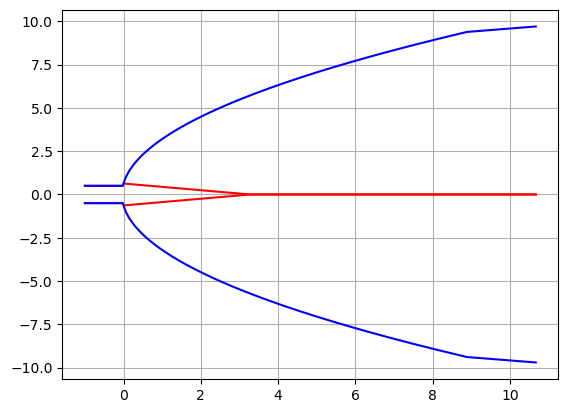

In [22]:
L_ = np.linspace(-1*De, 1.2*La, 500) # mm
rc = np.array([Dc(L)/2 for L in L_]) # mm
rj = np.array([Dj(L)/2 for L in L_]) # mm

plt.plot(L_/De, rc/De, 'r')
plt.plot(L_/De, -rc/De, 'r')
plt.plot(L_/De, rj/De, 'b')
plt.plot(L_/De, -rj/De, 'b')

plt.grid()

plt.show()

# 4. Pressure distribution
### ANSI/ANS-58.2-1988, Appendix D.
#### Section D1. Jet Impingement Force
#### Section D3. Jet Pressure - D3.1 Circumferential or Longitudinal Break with Full Separation.

* Jet force: $F_j = A_e(C_T P_0 - P_{amb})$

* Pressure distribution:

    - Region 1 ($0<= L <= L_c$), jet core ($0<= r <= D_c/2$): $$ P_j = P_{0e} = \frac{F_j}{A_{je}}$$
 
    - Region 1 ($0<= L <= L_c$), outside jet core ($D_c/2<= r <= D_j/2$):
    $$
    \frac{P_j}{P_{0e}} = 
    \begin{cases}
    \left(\frac{D_j-2r}{D_j-D_c}\right) \left(1 - \frac{2(D_j^2+D_jD_c+D_c^2-3D_e^2C_{Te}^*)}{D_j^2-D_c^2}\left(\frac{2r-D_c}{D_j-D_c}\right)\right) &
    \left(\frac{D_j}{D_e}\right)^2 + 2 \frac{D_jD_c}{D_e^2} + 3\left(\frac{D_c}{D_e}\right)^2 < 6C_{T}\\
    \left(\frac{D_j-2r}{D_j-D_c}\right)^2 \left(\frac{6(D_e^2C_{T}-D_c^2)}{(D_j-D_c)(D_j+3D_c)}\right) &
    \left(\frac{D_j}{D_e}\right)^2 + 2 \frac{D_jD_c}{D_e^2} + 3\left(\frac{D_c}{D_e}\right)^2 > 6C_{T}
    \end{cases}
    $$
    - Region 2 ($L_c<= L <= L_a$), jet centerline ($r=0$):
    $$
    \frac{P_{jc}}{P_{0e}} = F_c - \left( F_c - 3C_{T}\left(\frac{D_e}{D_a}\right)^2 \right)\frac{L_a}{L}\left(\frac{L-L_c}{L_a-L_c}\right)
    $$
    with
    $$
    F_c =
    \begin{cases}
    1.0 & (D_j(L=L_c)/D_e)^2 < 6C_{T}\\
    6C_{T}(D_e/D_j)^2 & (D_j(L=L_c)/D_e)^2 > 6C_{T}
    \end{cases}
    $$
    - Region 2 ($L_c<= L <= L_a$), general ($r<D_j/2$):
    $$
    \frac{P_j}{P_{jc}} = \left(1-\frac{2r}{D_j}\right)\left(1-2\frac{2r}{D_j}\left(1-3C_T\left(\frac{D_e}{D_j}\right)^2\frac{P_{0e}}{P_{jc}}\right)\right)
    $$
    - Region 3 ($L>=$), general ($r<D_j/2$):
    $$
    \frac{P_j}{P_{jc}} = \frac{D_j-2r}{D_j}\text{, with }P_{jc} = 3\frac{F_j}{A_j}
    $$

In [23]:
Fj = Ae * CT0 * P0 # N
Fj

19.49986640850494

In [24]:
def Pj(L, r):
    dc = Dc(L) # mm
    dj = Dj(L) # mm
    P0e = Fj/Aje # MPa
    if r > dj/2:
        return 0
    if L < 0:
        Pj = P0 # MPa
    elif L < Lc:
        if r < dc/2:
            Pj = P0e # MPa
        else:
            if (dj/De)**2 + 2*(dj*dc/De**2) + 3*(dc/De)**2 < 6*CTe:
                Pj = P0e * (dj-2*r)/(dj-dc) * (1 - 2*(dj**2+dj*dc+dc**2-3*De**2*CTe)/(dj**2-dc**2) * (2*r-dc)/(dj-dc)) # MPa
            else:
                Pj = P0e * ((dj-2*r)/(dj-dc))**2 * 6*(De**2*CTe-dc**2)/((dj-dc)*(dj+3*dc)) # MPa
    elif L < La:
        Fc = 1. if (Dj(Lc)/De)**2 <= 6*CTe else 6*CTe*(De/Dj(Lc))**2
        Pjc = P0e * (Fc - (Fc - 3*CTe*(De/Da)**2) * La/L * (L-Lc)/(La-Lc)) # MPa
        Pj = Pjc * (1 - 2*r/dj) * (1 - 2*(2*r/dj)*(1 - 3*CTe*(De/dj)**2*(P0e/Pjc))) # MPa
    else:
        Pjc = 3 * Fj / Aj(L) # MPa
        Pj = Pjc * (dj - 2*r) / dj # MPa
    return Pj # MPa

### Comparison with isobars presented in NEI 04-07 (2004), Appendix D.

C:\Users\iabbate\AppData\Local\Temp\ipykernel_15596\2731488943.py:11: UserWarning: Log scale: values of z <= 0 have been masked
  CS = plt.contour(L_/De, 2*r_/De, Pj_/psi2MPa, levels, norm=LogNorm(), cmap=cm.jet)


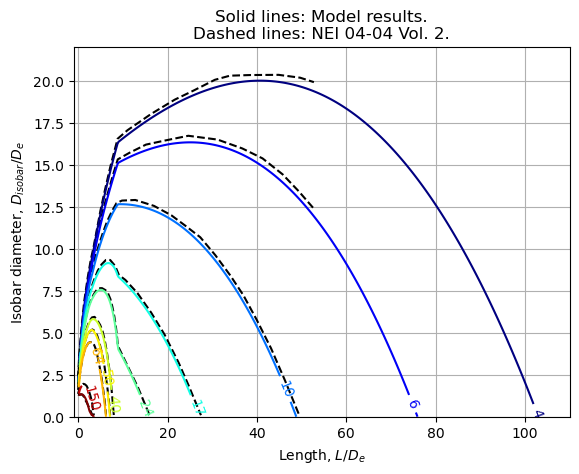

In [25]:
L_ = np.linspace(-1*De, 110*De, 500) # mm
r_ = np.linspace(0, 11*De, 200) # mm
Pj_ = np.array([[Pj(L, r) for L in L_] for r in r_])
levels = [4, 6, 10, 17, 24, 40, 50, 64, 150, 190]

L__ = read_data("graficas/NEI 04-07 V2 - Fig 3-1.csv")
for Lplot in L__:
    plt.plot(Lplot[:,0], 2*Lplot[:,1], 'k--')

levels = np.array(levels)
CS = plt.contour(L_/De, 2*r_/De, Pj_/psi2MPa, levels, norm=LogNorm(), cmap=cm.jet)
plt.clabel(CS)
plt.grid()
plt.title("Solid lines: Model results.\nDashed lines: NEI 04-04 Vol. 2.")
plt.ylabel('Isobar diameter, $D_{isobar}/D_e$')
plt.xlabel('Length, $L/D_e$')
plt.show()

C:\Users\iabbate\AppData\Local\Temp\ipykernel_15596\143141107.py:11: UserWarning: Log scale: values of z <= 0 have been masked
  CS = plt.contour(L_/De, 2*r_/De, Pj_/psi2MPa, levels, norm=LogNorm(), cmap=cm.jet)


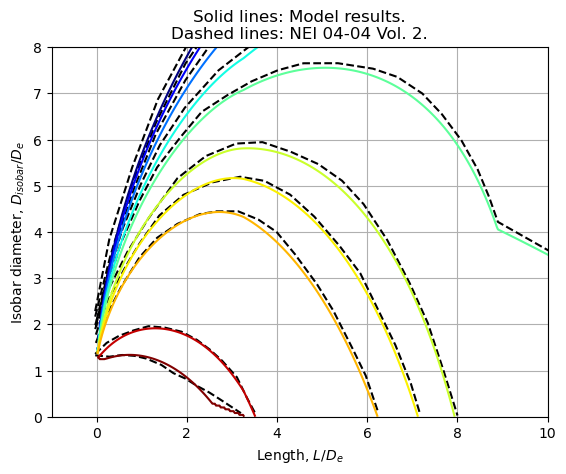

In [26]:
L_ = np.linspace(-1*De, 12*De, 500) # mm
r_ = np.linspace(0, 4*De, 200) # mm
Pj_ = np.array([[Pj(L, r) for L in L_] for r in r_])
levels = [4, 6, 10, 17, 24, 40, 50, 64, 150, 190]

L__ = read_data("graficas/NEI 04-07 V2 - Fig 3-1.csv")
for Lplot in L__:
    plt.plot(Lplot[:,0], 2*Lplot[:,1], 'k--')

levels = np.array(levels)
CS = plt.contour(L_/De, 2*r_/De, Pj_/psi2MPa, levels, norm=LogNorm(), cmap=cm.jet)
#plt.clabel(CS)
plt.grid()
plt.xlim(right=10)
plt.ylim(top=8)
plt.title("Solid lines: Model results.\nDashed lines: NEI 04-04 Vol. 2.")
plt.ylabel('Isobar diameter, $D_{isobar}/D_e$')
plt.xlabel('Length, $L/D_e$')
plt.show()

### Calculation of volumes and equivalent radii from isobar curves

Comparison with NEI 04-07 Vol. 1, Table 3-1.

C:\Users\iabbate\AppData\Local\Temp\ipykernel_15596\2705471720.py:6: UserWarning: Log scale: values of z <= 0 have been masked
  CS = plt.contour(L_/De, r_/De, Pj_/psi2MPa, levels, norm=LogNorm(), cmap=cm.jet)


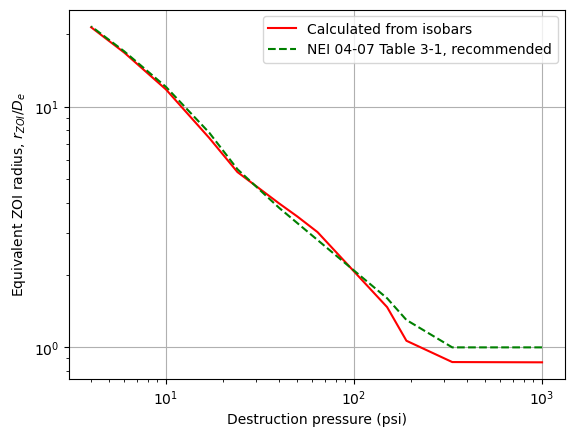

[21.40640371 16.79751456 11.80565496  7.41654744  5.35262782  3.96441153
  3.49758107  3.01276079  1.4700328   1.06540381  0.86889585  0.86669773]


In [27]:
L_ = np.concatenate((np.linspace(-1*De, 4*De, 200), np.linspace(4*De, 110*De, 100))) # mm
r_ = np.concatenate((np.linspace(0, 0.8*De, 200), np.linspace(0.8, 11*De, 100))) # mm
Pj_ = np.array([[Pj(L, r) for L in L_] for r in r_])
levels = [4, 6, 10, 17, 24, 40, 50, 64, 150, 190, 333, 1000]
levels = np.array(levels)
CS = plt.contour(L_/De, r_/De, Pj_/psi2MPa, levels, norm=LogNorm(), cmap=cm.jet)
plt.ylim(top=1)
plt.xlim(right=4)
plt.close()

paths = CS.get_paths()
vs = [path.vertices for path in paths]
vols = [np.pi*np.abs(np.trapz(v[:,1]**2, v[:,0])) for v in vs]
reqs = np.array([(3/4*2*v/np.pi)**(1/3) for v in vols])
plt.plot(levels, reqs/De, 'r', label="Calculated from isobars")

r_ = np.loadtxt("graficas/NEI 04-07 V1 - Table 3-1.txt", skiprows=1, delimiter="\t")
#plt.plot(r_[:,0], r_[:,1], 'b--', label="NEI 04-07 Table 3-1, calculated")
plt.plot(r_[:,0], r_[:,2], 'g--', label="NEI 04-07 Table 3-1, recommended")

plt.xscale('log')
plt.yscale('log')
plt.ylabel('Equivalent ZOI radius, $r_{ZOI}/D_e$')
plt.xlabel('Destruction pressure (psi)')
plt.legend()
plt.grid()
plt.show()
print(reqs/De)

Comparison with NEI 04-07 Vol. 2, Sample calculation Case 10.

C:\Users\iabbate\AppData\Local\Temp\ipykernel_15596\4053833959.py:6: UserWarning: Log scale: values of z <= 0 have been masked
  CS = plt.contour(L_/De, r_/De, Pj_/psi2MPa, levels, norm=LogNorm(), cmap=cm.jet)


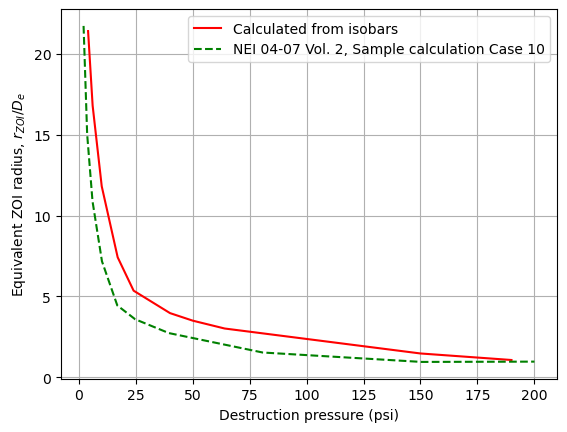

In [28]:
L_ = np.concatenate((np.linspace(-1*De, 4*De, 80), np.linspace(4*De, 110*De, 100))) # mm
r_ = np.concatenate((np.linspace(0, 0.8*De, 40), np.linspace(0.8, 11*De, 100))) # mm
Pj_ = np.array([[Pj(L, r) for L in L_] for r in r_])
levels = [4, 6, 10, 17, 24, 40, 50, 64, 150, 190]
levels = np.array(levels)
CS = plt.contour(L_/De, r_/De, Pj_/psi2MPa, levels, norm=LogNorm(), cmap=cm.jet)
plt.ylim(top=1)
plt.xlim(right=4)
plt.close()

paths = CS.get_paths()
vs = [path.vertices for path in paths]
vols = [np.pi*np.abs(np.trapz(v[:,1]**2, v[:,0])) for v in vs]
reqs = np.array([(3/4*2*v/np.pi)**(1/3) for v in vols])
plt.plot(levels, reqs/De, 'r', label="Calculated from isobars")

r_ = np.loadtxt("graficas/NEI 04-07 V2 - Fig I-18.csv", skiprows=1, delimiter=";")
plt.plot(r_[:,0], r_[:,1], 'g--', label="NEI 04-07 Vol. 2, Sample calculation Case 10")

plt.ylabel('Equivalent ZOI radius, $r_{ZOI}/D_e$')
plt.xlabel('Destruction pressure (psi)')
plt.legend()
plt.grid()
plt.show()

In order to properly compare the calculated curve with the curve for NEI 04-07 Vol. 2, Sample calculation Case 10, select the input parameters relative to this case, and run again the model.